# VII. Commodities Counting

## 1 Adding Quantity/Number Information to Lemmas

The first step is to extract lemmas representing numbers from the rest of our data. To do this, we simply look for all words whose lemma ends in 'NU', storing these in the variable `numbers_df`. Note that the indexes are not re-assigned from `words_df`, so we can still use `numbers_df` to determine the index of a number-lemma in the `words_df` frame.

In [ ]:
# note that 'NU$' is a regular expression, so the $ indicates that the 'NU'
# must be at the end of the string.
numbers_df = words_df[words_df['lemma'].str.contains('NU$')].copy()

With that out of the way, we next need to do the following:


1.   Identify all consecutive sequences of number-lemmas ('number blocks') on a line.
2.   Develop a method to convert the number blocks from (1) into integer or decimal format.
3.   Associate the lemma that immediately follows a number block from (1) with the converted integer from (2), and add this information back into the `words_df` frame.

### 1.1 Identifying Number Blocks

In [ ]:
def search_for_number_blocks(numb_df):
  number_blocks = [] # this will be a list-of-lists, which each sub-list 
                     # representing the indexes of one number block   
  
  current_block = [] # the current number block we are building
  
  # loop through all number lemmas
  for i in range(0, len(numb_df.index) - 2):
    # note that these represent indexes in the words_df frame as whole
    this_index = numb_df.index[i]
    next_index = numb_df.index[i+1]
    current_block.append(numb_df.index[i])
    
    # there are 3 cases where we have reached the end of a block. First, if the
    # index of the next lemma isn't immediately after the current one. Second,
    # if the next lemma is on a different line. Third, if the next lemma is in a
    # different tablet (to deal with the case of two one-line tablets in a row).
    if next_index != this_index + 1:
      number_blocks.append(current_block)
      current_block = []
    elif numb_df.at[this_index, 'id_line'] != numb_df.at[next_index, 'id_line']:
      number_blocks.append(current_block)
      current_block = []
    elif numb_df.at[this_index, 'id_text'] != numb_df.at[next_index, 'id_text']:     
      number_blocks.append(current_block)
      current_block = []
  return number_blocks

### 1.2 Converting Number Blocks to a Numerical Format

The second part is a bit more involved. We break it up into three separate functions, with the last function using the first two.

In the first of these, `add_number_block_column`, we both check that the words following a number block are indeed on the same line, and if so add the block to a new dataframe indexed by the location of the word that follows.

Second, we have `convert_single_counting_number`, which converts the (Arabic) numerals given in the lemmatization into a proper number.

Third, we build on `convert_single_counting_number` in `get_comm_count`. This uses the previous function to convert the Arabic numerals in a number block, then multiplies that by the approporiate weight of the unit used in the Sumerian number system.



In [ ]:
def add_number_block_column(number_blocks, words_frame):
  out_words_frame = words_frame.copy() 
  item_locs = []
  good_blocks = []
  for block in number_blocks:
    if words_frame.at[block[-1], 'id_line'] != words_frame.at[block[-1] + 1, 'id_line']:
      pass
    elif words_frame.at[block[-1], 'id_text'] != words_frame.at[block[-1] + 1, 'id_text']:
      pass
    else:
      item_locs.append(block[-1] + 1)
      good_blocks.append(block)
  number_indexes = pd.Series(data=good_blocks, index=item_locs)
  return number_indexes

In [ ]:
def convert_single_counting_number(num_str):
  count = 0
  grouping_name = ''
  bracket_string = re.search('\[.*\]', num_str).group()
  if bracket_string == '[]':
    count = float(Fraction(re.match('^[0-9/]*', num_str).group()))
    grouping_name = re.search('\(.*\)', num_str).group()[1:][:-1]
  else:
    count = 1
    grouping_name = num_str[0:num_str.index('[')]
  return [count, grouping_name]

In [ ]:
# A dictionary for converting terms to the quantity the represent.
grouping_dict = {'diš@t':1, 'diš': 1, 'min':2,'eš':3, 'limmu':4, 'ja':5, 'aš':6, 
            'aš@c':6, 'umun':7,'ussu':8,'ilimmu':9,'u':10, 
            'niš':20, 'ušu':30, 'nimin': 40, 'ninnu':50, 
            'geš₂':60, 'ĝeš-min':120, 'gešʾu':600, 
            'ĝes-u-min':1200, 'šar₂':3600,'sila': 1, 'barig':60, 'ban₂':10, 
            'gur':300}

def get_comm_count(word_index, comm_series, numb_df):
  number_block = comm_series.at[word_index]
  numb_df.loc[number_block, 'lemma']
  converted_nums = numb_df.loc[number_block, 'lemma'].apply(convert_single_counting_number)
  try:
    return sum(converted_nums.apply(lambda x: (x[0] * grouping_dict[x[1]]))), list(converted_nums.apply(lambda x: x[1]))
  except:
    return None, list(converted_nums.apply(lambda x: x[1]))

### 1.3 Adding Number Values to words_df

Given that the previous steps have been performed, the final procedure is to associated the calculated number with a lemma in `words_df`. In particular, we attach it to the lemma that immediately follows the number block, but in the future, a more sophisticated method may be used to ensure it is attached to a commodity.

In [ ]:
def add_comm_counts_to_words_df(words_frame, comm_idx, numb_df):
  counts = []
  units = []
  for index in comm_idx.index:
    count, unit = get_comm_count(index, comm_idx, numb_df)
    counts.append(count)
    units.append(unit)
  comm_count = pd.Series(data = counts, index = comm_idx.index)
  units_found = pd.Series(data = units, index = comm_idx.index)
  new_words_frame = words_frame.copy()
  new_words_frame['comm_count'] = comm_count
  new_words_frame['units_found'] = units_found
  return new_words_frame

In [ ]:
# Ensure the lemma string is in one of the correct formats.
numbers_df = numbers_df.loc[( numbers_df['lemma'].str.match('[0-9/]*\(.*\)\[\]NU') | numbers_df['lemma'].str.match('.*\[.+\]NU'))]
comm_idx = add_number_block_column(search_for_number_blocks(numbers_df), words_df)

In [ ]:
out = add_comm_counts_to_words_df(words_df, comm_idx, numbers_df)

## 2 Cleaning Our Data

There are several uncertainties and inaccuracies that remain in our data. For one, much of our future analysis will look at changes in commodities over time, but many of the tablets have near-illegible or multiple dates. Before we continue, we must filter these out.

Secondly, lemmas with the same transliteration are occasionally mistaken for one another. This can be quite problematic since oftentimes the typical quantity of one is much greater than the other. To attempt to detect when this has occurred, we eliminate commodities whose largest count is over five times that of its second largest.

Another potential issue is that many lemmas were only used in a few tablets from a limited selection of years. In such a case they tell us very little about overall changes to the Ur III economy throughout its existence. Therefore we exclude commodities that occur in fewer than 10 years.

In [ ]:
valid_counts = out.dropna()
valid_counts = valid_counts[(valid_counts['questionable'] == False) & (valid_counts['metadata_source_x'] == 'BDTNS') & (valid_counts['multiple_dates'] == False) & (valid_counts['ftype'] != 'yn')]

In [ ]:
unreliable_lemmas = []
for lemma in list(set(valid_counts['lemma'])):
  ordered_vals = list(valid_counts[valid_counts['lemma'] == lemma]['comm_count'].sort_values(ascending = False))
  years = list(valid_counts[valid_counts['lemma'] == lemma]['year'])
  if len(ordered_vals) > 1 and ordered_vals[0] > ordered_vals[1]*5: # filter out data with likely mislemmatization
    unreliable_lemmas.append(lemma)
  elif '[unit]' in lemma: # if this is a unit of measurement, for now we ignore it
    unreliable_lemmas.append(lemma)
  elif len(years) < 10: # if a lemma only appears in a few years throw it out
    unreliable_lemmas.append(lemma)


In [ ]:
valid_counts = valid_counts.drop(valid_counts['lemma'][valid_counts['lemma'].isin(unreliable_lemmas)].index)

## 3 Refining Our Commodity Search

In [ ]:
class Lemma:
  def __init__(self, transliteration = '.*', definition = '.*', pos = '.*', plaintext_alias = None):
    self.transliteration = transliteration
    self.definition = definition
    self.pos = pos
    self.regex_seed = f'(({transliteration})\[({definition})\]({pos}))'
    self.plaintext_alias = plaintext_alias
  
  def lookup(self, words_frame):
    return words_frame['lemma'].str.contains(self.regex_seed)
  
  def merge_matches(self, words_frame):
    out_frame = words_frame.copy()
    locations = self.lookup(out_frame)
    if ~locations.any():
      return out_frame
    replacement_string = self.plaintext_alias if self.plaintext_alias is not None else re.escape(self.regex_seed)
    out_frame['lemma'][locations] = replacement_string
    return out_frame

In [ ]:
def lookup_lines_of_lemma(lemma, words_frame):
  filtered_frame = words_frame.copy()
  filtered_frame = filtered_frame[filtered_frame['lemma'].str.match(lemma.regex_seed)]
  return filtered_frame[['id_text', 'id_line', 'lemma']].groupby(by=['id_text', 'id_line']).indices

In [ ]:
def lookup_forward_neighbors(lemma, words_frame, leap_size = 1):
  return words_frame.loc[(words_frame.loc[words_frame['lemma'].str.fullmatch(lemma.regex_seed)].index + 1)[:(-leap_size)]]

In [ ]:
def lookup_backwards_neighbors(lemma, words_frame, leap_size = 1):
  return words_frame.loc[(words_frame.loc[words_frame['lemma'].str.fullmatch(lemma.regex_seed)].index - leap_size)[leap_size:]]

In [ ]:
reduced_words_df = words_df[['lemma', 'id_text', 'id_line', 'id_word', 'label']]

In [ ]:
delivery_texts = [key[0] for key in lookup_lines_of_lemma(Lemma('mu.DU','delivery'), reduced_words_df).keys()]
expenditure_texts = [key[0] for key in lookup_lines_of_lemma(Lemma('ziga', 'expenditure'), reduced_words_df).keys()]
expenditure_texts.extend([key[0] for key in lookup_lines_of_lemma(Lemma('zig', 'rise'), reduced_words_df).keys()])

In [ ]:
# If a text only has mu.DU, then add it to delivery
valid_counts['delivery'] = valid_counts['id_text'].isin(delivery_texts) & ~valid_counts['id_text'].isin(expenditure_texts)

# If a text has zig or ziga, regardless of whether it has mu.DU, add it to expenditure
valid_counts['expenditure'] = valid_counts['id_text'].isin(expenditure_texts)

# Lastly, create a category that contains both sets of texts
valid_counts['delivery_or_expenditure'] = valid_counts['id_text'].isin(expenditure_texts) | valid_counts['id_text'].isin(delivery_texts)

In [ ]:
lookup_backwards_neighbors(Lemma('mu.DU', 'delivery', 'N'), reduced_words_df, 2)

,lemma,id_text,id_line,id_word,label
220,Urum[1]SN,P100217,12,P100217.12.4,r 2
260,ensik[ruler]N,P100219,8,P100219.8.1,o 6
303,1(diš)[]NU,P100221,4,P100221.4.1,o 2
366,ud[sun]N,P100222,16,P100222.16.1,r 6
505,sila[lamb]N,P100228,4,P100228.4.2,o 2
...,...,...,...,...,...
579201,sila[lamb]N,P517184,4,P517184.4.2,o 2
579208,sila[lamb]N,P517184,6,P517184.6.2,o 4
579217,sila[lamb]N,P517184,9,P517184.9.2,o 7
579226,niga[fattened]V/i,P517184,12,P517184.12.3,o 10


## 4 Exploring all the Texts

In [ ]:
generic_goat_lemma = Lemma(definition='~?goat', plaintext_alias='maš[goat]N')
generic_sheep_lemma = Lemma(definition='~?sheep', plaintext_alias='udu[sheep]N')

In [ ]:
comm_counts = valid_counts.copy()
comm_counts = comm_counts.loc[(comm_counts['lemma'].str.contains(']N$'))]
comm_counts = comm_counts.loc[~(comm_counts['lemma'].str.contains('year$'))]

In [ ]:
sheep_n_goats = generic_goat_lemma.merge_matches(comm_counts)
sheep_n_goats = generic_sheep_lemma.merge_matches(sheep_n_goats)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
commodities_by_year = valid_counts[['lemma', 'min_year', 'comm_count']].groupby(by=['lemma', 'min_year']).sum()

In [ ]:
sheep_n_goats_by_year = sheep_n_goats[['lemma', 'min_year', 'comm_count']].groupby(by=['lemma', 'min_year']).sum()

In [ ]:
commodities_by_year.sort_values(by = 'comm_count', ascending=False)

comm_count
lemma                min_year              
udu[sheep]N          71.0      91183.000000
                     70.0      87813.000000
x[NA]NA              70.0      85703.000000
gun[load]N           85.0      82026.000000
itud[moon]N          83.0      55220.000000
...                                     ...
ma-na[]PN            63.0          0.500000
a-geš-IGI-ri[]PN     83.0          0.500000
niŋlalarum[dessert]N 84.0          0.500000
išah[lard]N          70.0          0.500000
šu-{d}iškur[]PN      58.0          0.333333

[2688 rows x 1 columns]

In [ ]:
tablets_by_time = words_df[(words_df['questionable'] == False) & (words_df['metadata_source_x'] == 'BDTNS') & (words_df['multiple_dates'] == False)][['min_year', 'id_text']].groupby(by = 'min_year').nunique()

In [ ]:
words_by_time = words_df[(words_df['questionable'] == False) & (words_df['metadata_source_x'] == 'BDTNS') & (words_df['multiple_dates'] == False)][['min_year', 'id_text']].groupby(by = 'min_year').count()

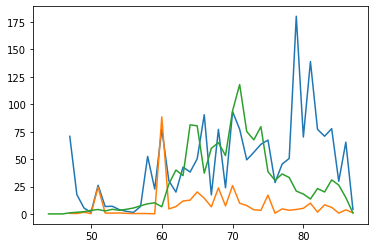

In [ ]:
import matplotlib.pyplot as plt
plt.plot((commodities_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text']).index, commodities_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text'])
plt.plot((commodities_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text']).index, commodities_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text'])
#plt.plot(commodities_by_year.loc['maš[goat]N'].index,  commodities_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text'])
plt.plot(tablets_by_time.index, tablets_by_time/10)

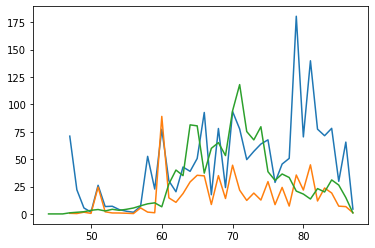

In [ ]:
plt.plot((sheep_n_goats_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text']).index, sheep_n_goats_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text'])
plt.plot((sheep_n_goats_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text']).index, sheep_n_goats_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text'])
plt.plot(tablets_by_time.index, tablets_by_time/10)

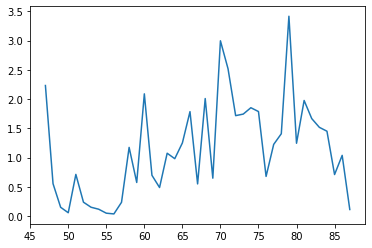

In [ ]:
plt.plot((commodities_by_year.loc['udu[sheep]N']['comm_count']/words_by_time['id_text']).index, commodities_by_year.loc['udu[sheep]N']['comm_count']/words_by_time['id_text'])


In [ ]:
relative_spike = (commodities_by_year.loc['udu[sheep]N']['comm_count']/words_by_time['id_text']).dropna()

In [ ]:
relative_spike.sort_values(ascending=False)

min_year
79.0    3.415813
70.0    2.996315
71.0    2.518033
47.0    2.232092
60.0    2.089681
68.0    2.009363
81.0    1.976220
74.0    1.852672
75.0    1.787211
66.0    1.785718
73.0    1.743820
72.0    1.717206
82.0    1.666760
83.0    1.517521
84.0    1.450986
78.0    1.407816
65.0    1.250905
80.0    1.245296
77.0    1.225937
58.0    1.174519
63.0    1.074880
86.0    1.038360
64.0    0.981723
51.0    0.713147
85.0    0.710645
61.0    0.697853
76.0    0.678775
69.0    0.648679
59.0    0.575142
48.0    0.554688
67.0    0.550728
62.0    0.488782
52.0    0.238155
57.0    0.235935
53.0    0.151741
49.0    0.151239
54.0    0.118158
87.0    0.113158
50.0    0.057937
55.0    0.050339
56.0    0.037833
dtype: float64

(30.0, 90.0)

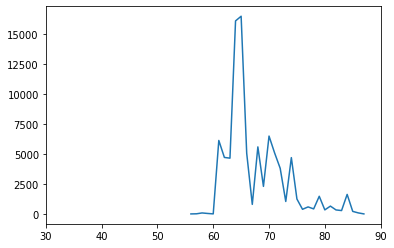

In [ ]:
plt.plot(commodities_by_year.loc['u[ewe]N'].index, commodities_by_year.loc['u[ewe]N'])

plt.xlim(30, 90)

## 5 Exploring Expenditure Texts

In [ ]:
delivery_by_year = valid_counts.loc[valid_counts['delivery'], ['lemma', 'min_year', 'comm_count']].groupby(by=['lemma', 'min_year']).sum()
expenditure_by_year = valid_counts.loc[valid_counts['expenditure'], ['lemma', 'min_year', 'comm_count']].groupby(by=['lemma', 'min_year']).sum()
both_by_year =  valid_counts.loc[valid_counts['delivery_or_expenditure'] , ['lemma', 'min_year', 'comm_count']].groupby(by=['lemma', 'min_year']).sum()

A comparison of udu and mash (per tablet) over time in expenditure texts.

In [ ]:
expenditure_by_year.loc['ninda[bread]N']['comm_count']

min_year
58.0    120.0
61.0     60.0
65.0    140.0
75.0    250.0
Name: comm_count, dtype: float64

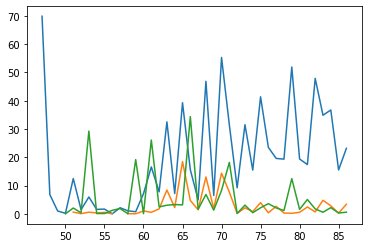

In [ ]:
plt.plot((expenditure_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text']).index, expenditure_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text'])
plt.plot((expenditure_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text']).index, expenditure_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text'])
#plt.plot((expenditure_by_year.loc['gun[load]N']['comm_count']/tablets_by_time['id_text']).index, expenditure_by_year.loc['gun[load]N']['comm_count']/tablets_by_time['id_text'])
plt.plot((expenditure_by_year.loc['gud[ox]N']['comm_count']/tablets_by_time['id_text']).index, expenditure_by_year.loc['gud[ox]N']['comm_count']/tablets_by_time['id_text'])
plt.plot((expenditure_by_year.loc['ninda[bread]N']['comm_count']/tablets_by_time['id_text']).index, expenditure_by_year.loc['ninda[bread]N']['comm_count']/tablets_by_time['id_text'])


#plt.plot(commodities_by_year.loc['maš[goat]N'].index,  commodities_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text'])
#plt.plot(tablets_by_time.index, tablets_by_time/10)

A comparison of udu in expediture and delivery texts.

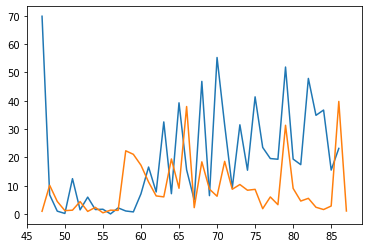

In [ ]:
plt.plot((expenditure_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text']).index, expenditure_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text'])
plt.plot((delivery_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text']).index, delivery_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text'])


A raw comparison of udu and mash in expenditure texts (not adjusted for number of tablets).

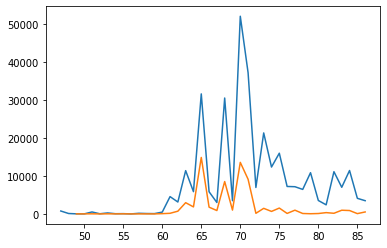

In [ ]:
plt.plot((expenditure_by_year.loc['udu[sheep]N']['comm_count']).index, expenditure_by_year.loc['udu[sheep]N']['comm_count'])
plt.plot((expenditure_by_year.loc['maš[goat]N']['comm_count']).index, expenditure_by_year.loc['maš[goat]N']['comm_count'])


A comparison of udu and mash in delivery (also adjusted).

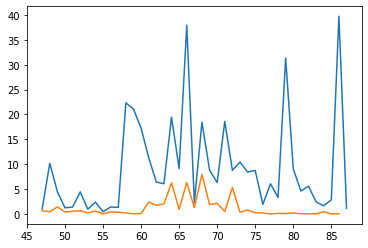

In [ ]:
plt.plot((delivery_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text']).index, delivery_by_year.loc['udu[sheep]N']['comm_count']/tablets_by_time['id_text'])
plt.plot((delivery_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text']).index, delivery_by_year.loc['maš[goat]N']['comm_count']/tablets_by_time['id_text'])